In [18]:

%load_ext autoreload
%autoreload 2

# %%
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
# %%
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.feature_reduction_lib import FEATURE_REDUCTION_DEFAULTS, LAYER_TRANSFORM_FILTERS
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_lib import sweep_regressors, transform_features2Xdict_new, transform_features2Xdict, RidgeCV, apply_feature_transforms
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths, extract_neural_data_dict_2025apr
#%% Utility Functions

dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
encoding_stim_dir = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025"
outputroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models"


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# load the train/test split
df_stim = pd.read_csv(join(encoding_stim_dir, "encoding_stimuli_split_seed0.csv"), )
train_idx = df_stim[df_stim["is_train"]].index


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [4]:
subject_id, filename = ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5")

In [6]:
print(subject_id)
data_path = join(dataroot, filename)
data = load_from_hdf5(data_path)
print(list(data))
data_dict = extract_neural_data_dict_2025apr(data)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [encoding_stim_dir], arbitrary_format=True)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

batch_size = 96

model_names = [
    # "AlexNet_training_seed_01",
    # "resnet50_robust",
    # "resnet50_clip",
    # "resnet50_dino",
    # "resnet50",
    # "regnety_640",
    "dinov2_vitb14_reg",
    # "clipag_vitb32",
    # "siglip2_vitb16",
    # "radio_v2.5-b",
    # "ReAlnet01",
]

output_subdir_name = "model_outputs_pca_vs_cls"


red_20250428-20250430
['README', 'neuron_metadata', 'repavg', 'stimulus_meta', 'trials']
All stimulus files were found


In [7]:
figdir = join(outputroot, subject_id, output_subdir_name)
os.makedirs(figdir, exist_ok=True)
# for modelname in model_names:
modelname = "dinov2_vitb14_reg"
print(f"\nTesting model: {modelname}")
try:
    # Load model and transforms
    model, transforms_pipeline = load_model_transform(modelname, device)
except Exception as e:  
    print(f"Error loading model {modelname}: {str(e)}")
    raise e
print(f"Successfully loaded model: {modelname}")
dataset = ImagePathDataset(image_fps, scores=None, transform=transforms_pipeline)
print(f"Successfully created dataset for {modelname} with {len(dataset)} images")
# Create feature fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
print(f"Successfully created feature fetcher for {modelname}")
# Get all module names
all_module_names = list(fetcher.module_names.values())
print(f"Total number of modules: {len(all_module_names)}")
# Get layer filter for this model
layer_filter = MODEL_LAYER_FILTERS[modelname]
layer_abbrev = LAYER_ABBREVIATION_MAPS[modelname]
# Count layers that pass the filter
module_names2record = [name for name in all_module_names if layer_filter(name)]
print(f"Number of layers passing filter: {len(module_names2record)}")
print(f"Filtered layer names: {module_names2record}")
module_names2record_abbrev = [layer_abbrev(name) for name in module_names2record]
print(f"Filtered layer names (abbreviated): {module_names2record_abbrev}")
# # hook the layers
for name in module_names2record: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
# Cleanup
print(f"{modelname} done!!!")
fetcher.cleanup()


Testing model: dinov2_vitb14_reg


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Successfully loaded model: dinov2_vitb14_reg
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for dinov2_vitb14_reg with 969 images
Successfully created feature fetcher for dinov2_vitb14_reg
Total number of modules: 187
Number of layers passing filter: 12
Filtered layer names: ['.blocks.NestedTensorBlock0', '.blocks.NestedTensorBlock1', '.blocks.NestedTensorBlock2', '.blocks.NestedTensorBlock3', '.blocks.NestedTensorBlock4', '.blocks.NestedTensorBlock5', '.blocks.NestedTensorBlock6', '.blocks.NestedTensorBlock7', '.blocks.NestedTensorBlock8', '.blocks.NestedTensorBlock9', '.blocks.NestedTensorBlock10', '.blocks.NestedTensorBlock11']
Filtered layer names (abbreviated): ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


  0%|          | 0/11 [00:00<?, ?it/s]

.blocks.NestedTensorBlock0 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock1 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock2 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock3 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock4 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock5 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock6 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock7 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock8 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock9 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock10 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock11 torch.Size([969, 261, 768])
dinov2_vitb14_reg done!!!
FeatureFetcher hooks all freed


In [8]:
dimred_transform_dict = FEATURE_REDUCTION_DEFAULTS[modelname](model)
layer_transform_filter = LAYER_TRANSFORM_FILTERS[modelname]
dimred_list = list(dimred_transform_dict.keys())
Xdict_lyrswp, Xtfmer_lyrswp = apply_feature_transforms(
    feat_dict_lyrswp, module_names2record, dimred_transform_dict, layer_transform_filter)

Time taken to transform .blocks.NestedTensorBlock0 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock0 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock0 x maxpool_space_token: 0.313s
Time taken to transform .blocks.NestedTensorBlock0 x avgpool_space_token: 0.066s
Time taken to transform .blocks.NestedTensorBlock0 x cls_cat_maxpool_space_token: 0.303s
Time taken to transform .blocks.NestedTensorBlock1 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock1 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock1 x maxpool_space_token: 0.274s
Time taken to transform .blocks.NestedTensorBlock1 x avgpool_space_token: 0.066s
Time taken to transform .blocks.NestedTensorBlock1 x cls_cat_maxpool_space_token: 0.275s
Time taken to transform .blocks.NestedTensorBlock2 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock2 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTens

### Compare PCA of everything with cls

In [11]:
dimred_list = ["pca750", "srp", ]
Xdict_lyrswp_pcssrp, Xtfmer_lyrswp_pcssrp = transform_features2Xdict_new(feat_dict_lyrswp, module_names2record, 
                    dimred_list=dimred_list, pretrained_Xtransforms={}, #  "srp"
                    use_pca_dual=True, use_srp_torch=True, train_split_idx=train_idx)

.blocks.NestedTensorBlock0 torch.Size([969, 261, 768])
Time taken to transform .blocks.NestedTensorBlock0 pca750 [969, 750]: 2.679s
Time taken to transform .blocks.NestedTensorBlock0 srp [969, 5893]: 5.126s
Time taken to transform .blocks.NestedTensorBlock0: 7.975s
.blocks.NestedTensorBlock1 torch.Size([969, 261, 768])
Time taken to transform .blocks.NestedTensorBlock1 pca750 [969, 750]: 0.648s
Time taken to transform .blocks.NestedTensorBlock1 srp [969, 5893]: 2.264s
Time taken to transform .blocks.NestedTensorBlock1: 3.083s
.blocks.NestedTensorBlock2 torch.Size([969, 261, 768])
Time taken to transform .blocks.NestedTensorBlock2 pca750 [969, 750]: 0.639s
Time taken to transform .blocks.NestedTensorBlock2 srp [969, 5893]: 2.317s
Time taken to transform .blocks.NestedTensorBlock2: 3.127s
.blocks.NestedTensorBlock3 torch.Size([969, 261, 768])
Time taken to transform .blocks.NestedTensorBlock3 pca750 [969, 750]: 0.639s
Time taken to transform .blocks.NestedTensorBlock3 srp [969, 5893]: 2.

In [13]:
Xdict_lyrswp_cls_pca = Xdict_lyrswp.copy()
Xdict_lyrswp_cls_pca.update(Xdict_lyrswp_pcssrp)
Xtfmer_lyrswp_cls_pca = Xtfmer_lyrswp.copy()
Xtfmer_lyrswp_cls_pca.update(Xtfmer_lyrswp_pcssrp)


Applied feature reduction: ['pca750', 'srp']
60 features computed! 
Fitting models for All channels N=64
Sweeping regressors: ['RidgeCV']
Using 774 training samples provided by train_split_idx and 195 testing samples
('.blocks.NestedTensorBlock0', 'cls_token') RidgeCV D2_train: 0.108 D2_test: 0.045 time: 0.243
('.blocks.NestedTensorBlock0', 'mean_register_token') RidgeCV D2_train: 0.122 D2_test: 0.050 time: 0.231
('.blocks.NestedTensorBlock0', 'maxpool_space_token') RidgeCV D2_train: 0.151 D2_test: 0.045 time: 0.236
('.blocks.NestedTensorBlock0', 'avgpool_space_token') RidgeCV D2_train: 0.131 D2_test: 0.049 time: 0.231
('.blocks.NestedTensorBlock0', 'cls_cat_maxpool_space_token') RidgeCV D2_train: 0.153 D2_test: 0.045 time: 0.180
('.blocks.NestedTensorBlock1', 'cls_token') RidgeCV D2_train: 0.154 D2_test: 0.072 time: 0.232
('.blocks.NestedTensorBlock1', 'mean_register_token') RidgeCV D2_train: 0.169 D2_test: 0.079 time: 0.231
('.blocks.NestedTensorBlock1', 'maxpool_space_token') RidgeC

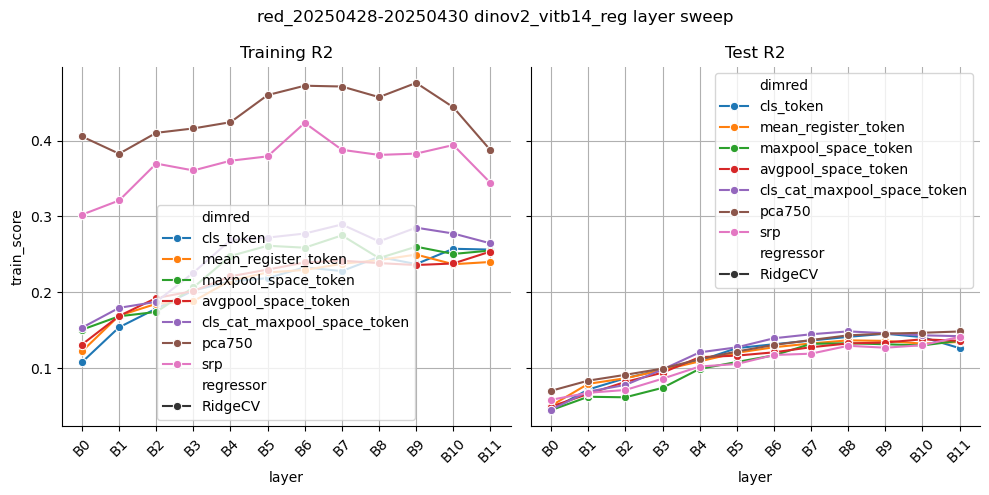

In [19]:
print(f"Applied feature reduction: {dimred_list}")
print(f"{len(Xdict_lyrswp)} features computed! ")

resp_mat_sel = resp_mat[:, :] # Select all channels, no mask
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
regressors = [RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], 
                    alpha_per_target=True,),
            # MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            ] 
regressor_names = ["RidgeCV"]
print(f"Sweeping regressors: {regressor_names}")
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp_cls_pca, resp_mat_sel, regressors, regressor_names, 
                                                    verbose=True, train_split_idx=train_idx)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp_cls_pca, resp_mat_sel, idx_train=train_idx) # Fixed the bug! now the train/test split is fixed
pkl.dump(pred_D2_dict, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
result_df_lyrswp.to_pickle(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
result_df_lyrswp = format_result_df(result_df_lyrswp, dimred_list)
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_formatted.csv"))

figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_pca_vs_cls", figh=figh)

/n/home12/binxuwang/Github/Closed-loop-visual-insilico/neural_regress/regress_eval_lib.py:178: RuntimeWarning: Mean of empty slice.
  {"train_score": D2_per_unit_train_masked.mean(), "test_score": D2_per_unit_test_masked.mean(), }
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Top 5 most reliability:  [0.87396659 0.86120418 0.83879821 0.83347315 0.81366443]
Top 5 most reliable channels idx:  [15  9 19  0  2]


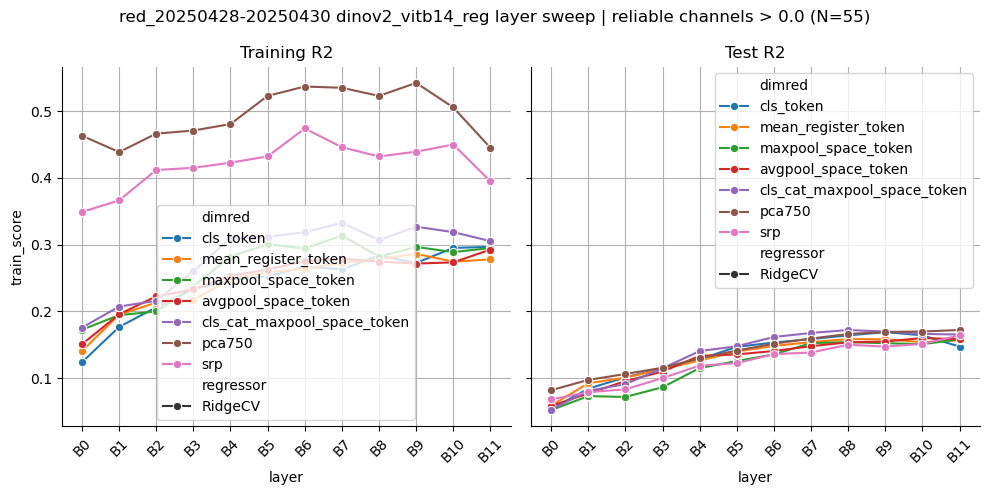

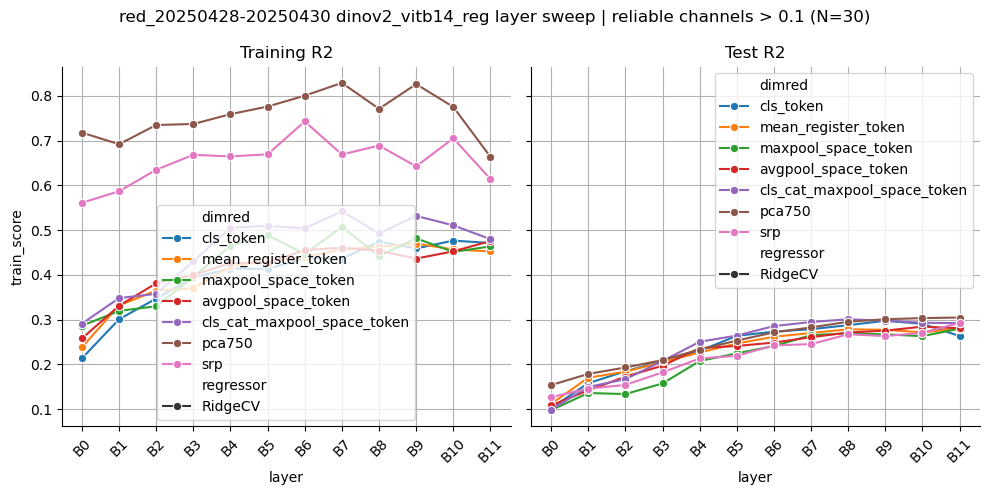

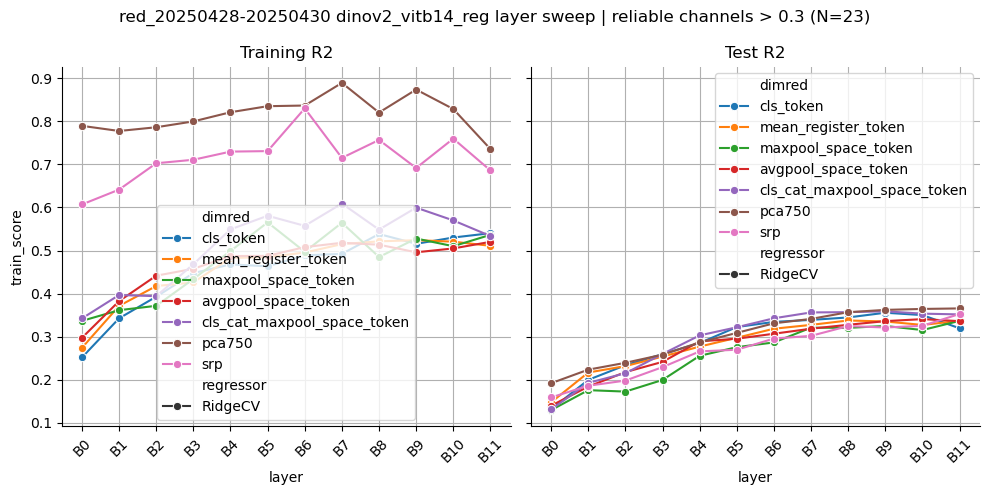

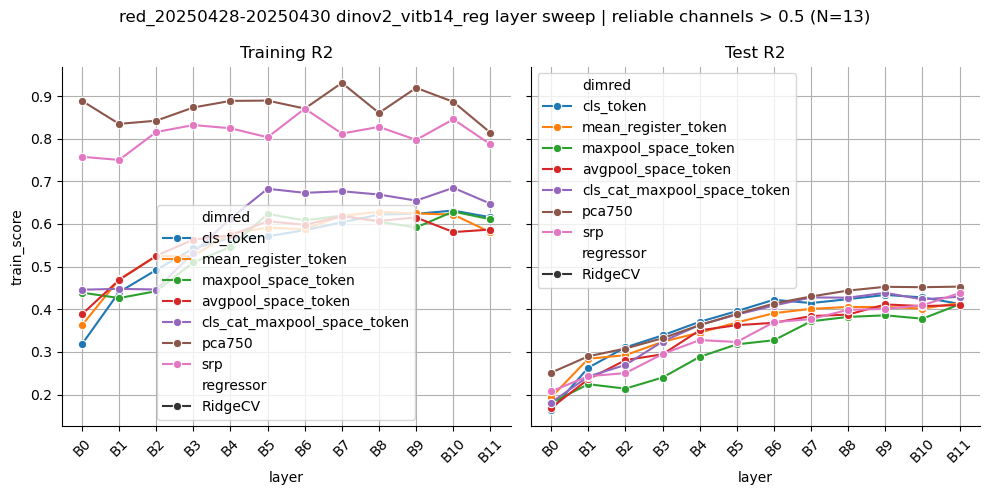

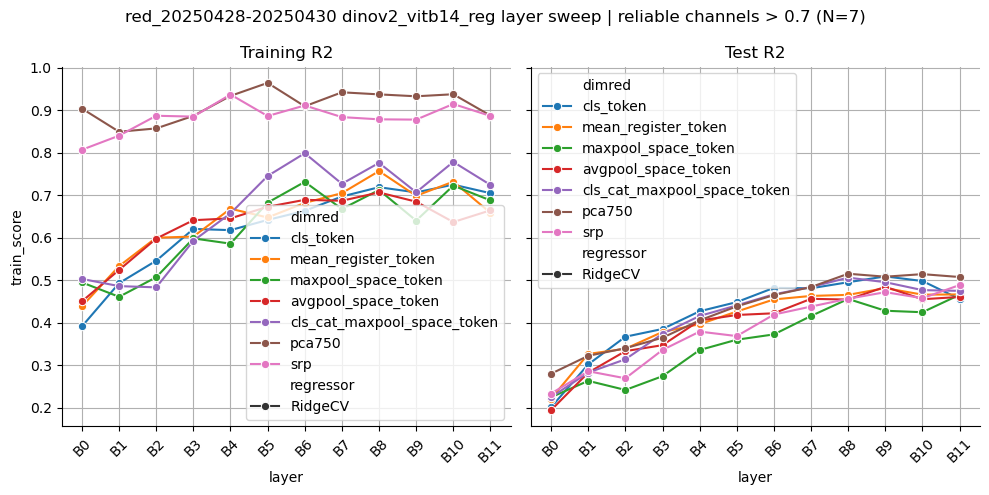

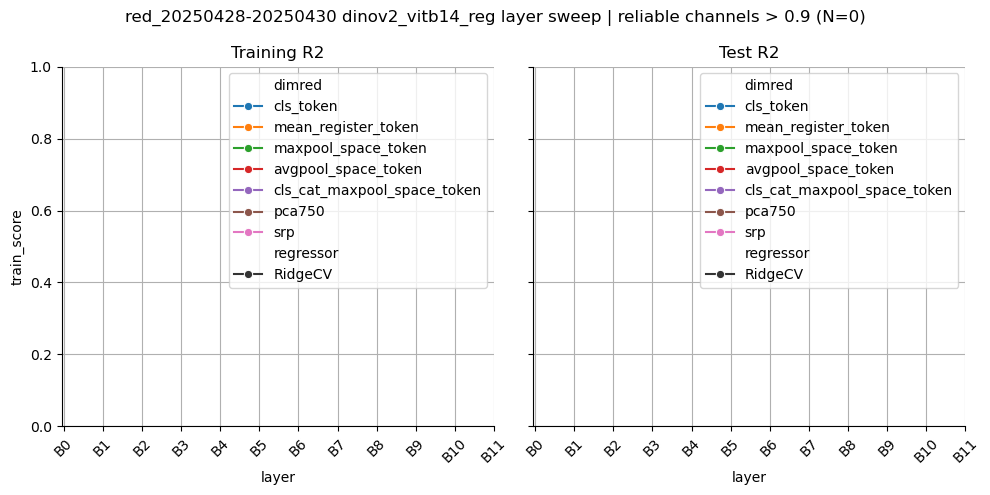

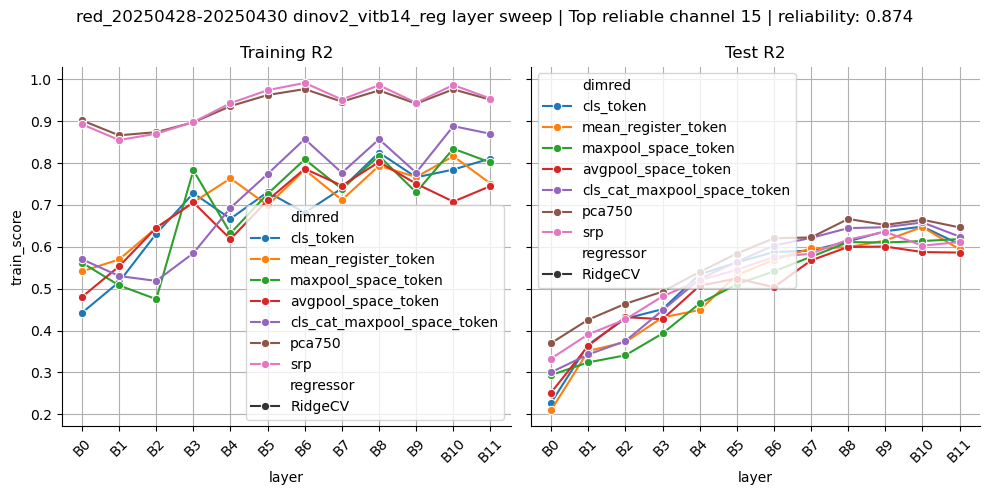

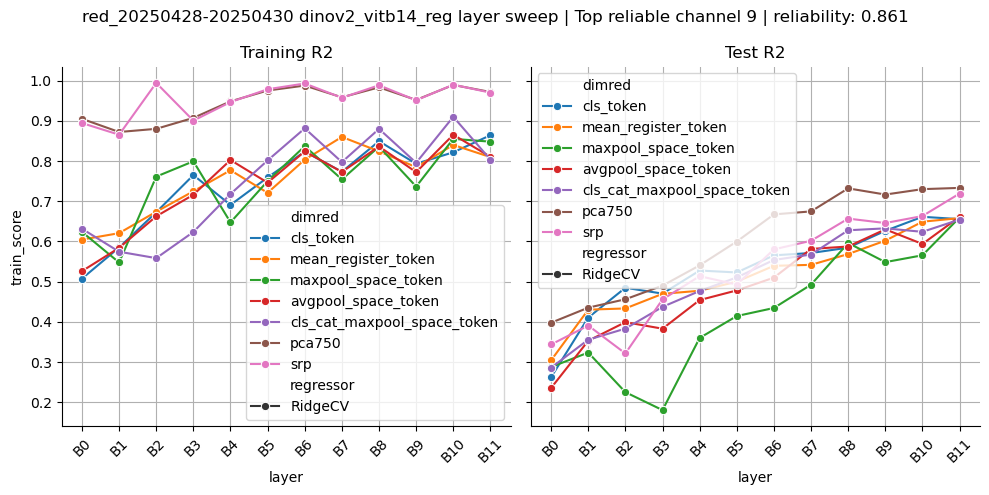

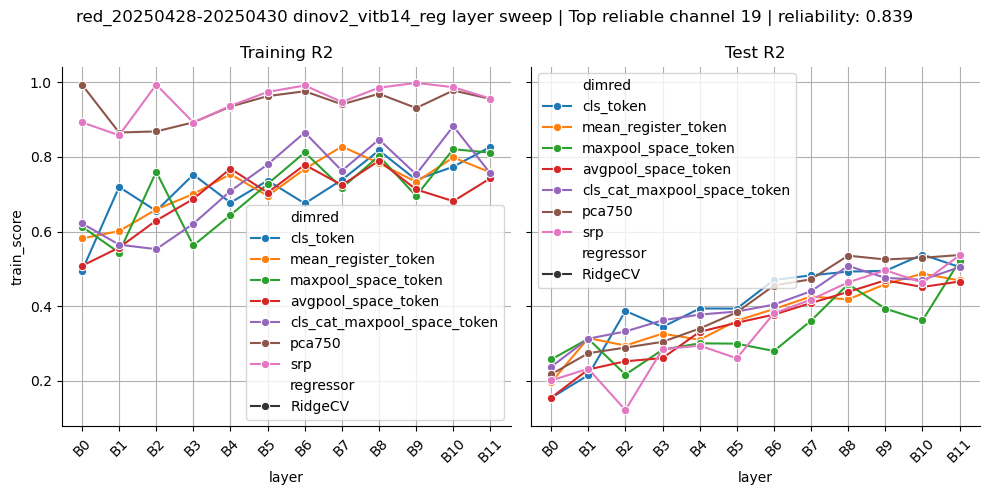

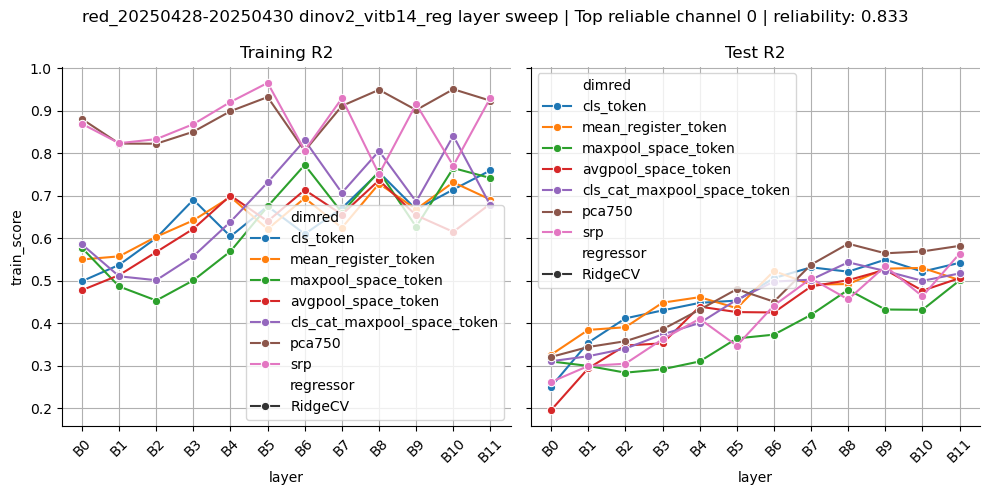

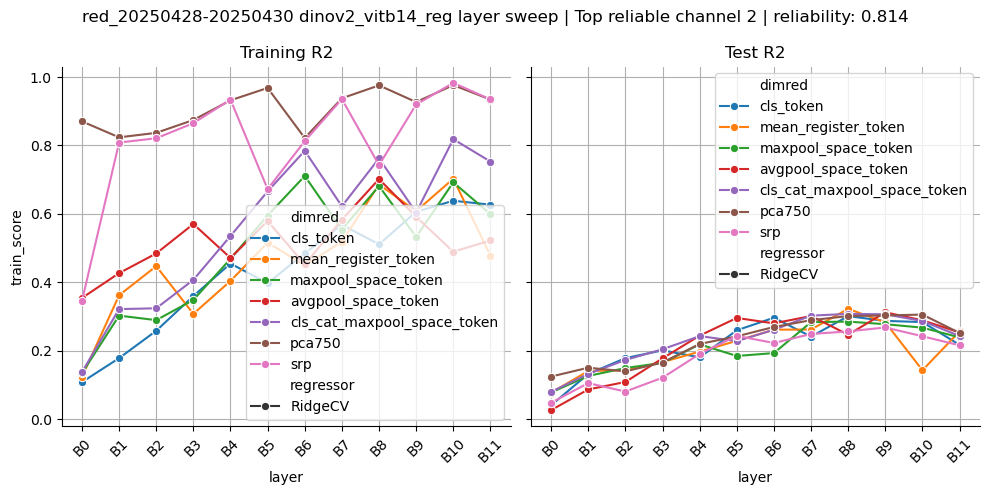

In [20]:
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh)
    figh = plot_result_df_per_layer(result_df_masked, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)

topk_reliable_chan_idx = np.argsort(reliability)[-5:][::-1]
topk_reliable = reliability[topk_reliable_chan_idx]
print("Top 5 most reliability: ", topk_reliable)
print("Top 5 most reliable channels idx: ", topk_reliable_chan_idx)
for idx in topk_reliable_chan_idx:
    single_chan_result_df = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=idx)
    figh = plot_result_df_per_layer(single_chan_result_df, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | Top reliable channel {idx} | reliability: {reliability[idx]:.3f}")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_single_reliable_Ch{idx:02d}", figh=figh)

# plt.close("all")
# if "resnet50" in modelname:
#     # if so, save the sparsified Xtfmer_lyrswp, not every layer 
#     Xtfmer_lyrswp_sparse = {k: v for k, v in Xtfmer_lyrswp.items() if ("layer4" in k or "layer4" in k[0])  and "pca" in k}
#     th.save(Xtfmer_lyrswp_sparse, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# try:
#     pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
# except:
#     pass

### Older version

In [9]:
# if modelname in FEATURE_REDUCTION_DEFAULTS and not ("resnet" in modelname):
#     # ViT models using the default feature reduction, pretrained feature reduction
#     dimred_transform_dict = FEATURE_REDUCTION_DEFAULTS[modelname](model)
#     layer_transform_filter = LAYER_TRANSFORM_FILTERS[modelname]
#     dimred_list = list(dimred_transform_dict.keys())
#     Xdict_lyrswp, Xtfmer_lyrswp = apply_feature_transforms(
#         feat_dict_lyrswp, module_names2record, dimred_transform_dict, layer_transform_filter)
# else:
#     # ResNet and other CNN models using the PCA / SRP feature reduction, pretrained feature reduction
#     dimred_list = ["pca750", "srp", ]
#     Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict_new(feat_dict_lyrswp, module_names2record, 
#                         dimred_list=dimred_list, pretrained_Xtransforms={}, #  "srp"
#                         use_pca_dual=True, use_srp_torch=True, train_split_idx=train_idx)

print(f"Applied feature reduction: {dimred_list}")
print(f"{len(Xdict_lyrswp)} features computed! ")

resp_mat_sel = resp_mat[:, :] # Select all channels, no mask
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
regressors = [RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], 
                    alpha_per_target=True,),
            # MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            ] 
regressor_names = ["RidgeCV"]
print(f"Sweeping regressors: {regressor_names}")
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, 
                                                    verbose=True, train_split_idx=train_idx)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel, idx_train=train_idx) # Fixed the bug! now the train/test split is fixed
pkl.dump(pred_D2_dict, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
result_df_lyrswp.to_pickle(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
result_df_lyrswp = format_result_df(result_df_lyrswp, dimred_list)
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_formatted.csv"))

figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)

Applied feature reduction: ['cls_token', 'mean_register_token', 'maxpool_space_token', 'avgpool_space_token', 'cls_cat_maxpool_space_token']
60 features computed! 
Fitting models for All channels N=64
Sweeping regressors: ['RidgeCV']
Using 774 training samples provided by train_split_idx and 195 testing samples
('.blocks.NestedTensorBlock0', 'cls_token') RidgeCV D2_train: 0.108 D2_test: 0.045 time: 0.760
('.blocks.NestedTensorBlock0', 'mean_register_token') RidgeCV D2_train: 0.122 D2_test: 0.050 time: 0.233
('.blocks.NestedTensorBlock0', 'maxpool_space_token') RidgeCV D2_train: 0.151 D2_test: 0.045 time: 0.240
('.blocks.NestedTensorBlock0', 'avgpool_space_token') RidgeCV D2_train: 0.131 D2_test: 0.049 time: 0.234
('.blocks.NestedTensorBlock0', 'cls_cat_maxpool_space_token') RidgeCV D2_train: 0.153 D2_test: 0.045 time: 0.218
('.blocks.NestedTensorBlock1', 'cls_token') RidgeCV D2_train: 0.154 D2_test: 0.072 time: 0.233
('.blocks.NestedTensorBlock1', 'mean_register_token') RidgeCV D2_trai

already formatted, pass


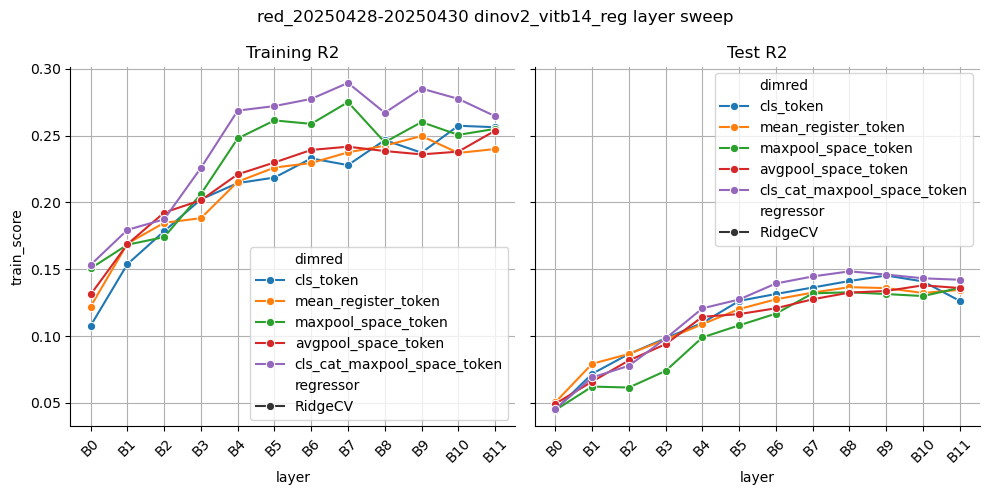

In [10]:
figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)

In [ ]:


# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh)
    figh = plot_result_df_per_layer(result_df_masked, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)

topk_reliable_chan_idx = np.argsort(reliability)[-5:][::-1]
topk_reliable = reliability[topk_reliable_chan_idx]
print("Top 5 most reliability: ", topk_reliable)
print("Top 5 most reliable channels idx: ", topk_reliable_chan_idx)
for idx in topk_reliable_chan_idx:
    single_chan_result_df = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=idx)
    figh = plot_result_df_per_layer(single_chan_result_df, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | Top reliable channel {idx} | reliability: {reliability[idx]:.3f}")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_single_reliable_Ch{idx:02d}", figh=figh)

plt.close("all")
if "resnet50" in modelname:
    # if so, save the sparsified Xtfmer_lyrswp, not every layer 
    Xtfmer_lyrswp_sparse = {k: v for k, v in Xtfmer_lyrswp.items() if ("layer4" in k or "layer4" in k[0])  and "pca" in k}
    th.save(Xtfmer_lyrswp_sparse, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
try:
    pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
except:
    pass